In [ ]:
# importing necessary libraries

import pandas as pd
import numpy as np
import cv2
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.utils import class_weight

import torch
import torch.nn as nn
from torch.nn import functional as F
from torchmetrics.classification import Accuracy

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/fer2013.csv")

# Data pre-processing

In [ ]:
# Function to apply contrast and denoise filters on images

def str2arr(img):

    img = [int(x) for x in img.split(" ")]
    img = np.array(img).reshape(48, 48).astype(np.uint8)

    # apply contrast
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(3, 3))
    img = clahe.apply(img)

    # apply denoise
    img = cv2.fastNlMeansDenoising(img, None, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)

    # normalize image
    img = img/255

    return img.reshape(48, 48, 1)


df['pixels'] = df['pixels'].apply(lambda x: str2arr(x))

In [ ]:
train = df[df.usage=='train']
test = df[df.usage=='test']

train.drop(columns=['usage'], inplace=True)
test.drop(columns=['usage'], inplace=True)
val, test = train_test_split(test, stratify=test['emotion'], test_size=0.5, random_state=42)

print("Train size", len(train))
print("Validation size", len(val))
print("Test size", len(test))

Train size 28709
Validation size 3589
Test size 3589


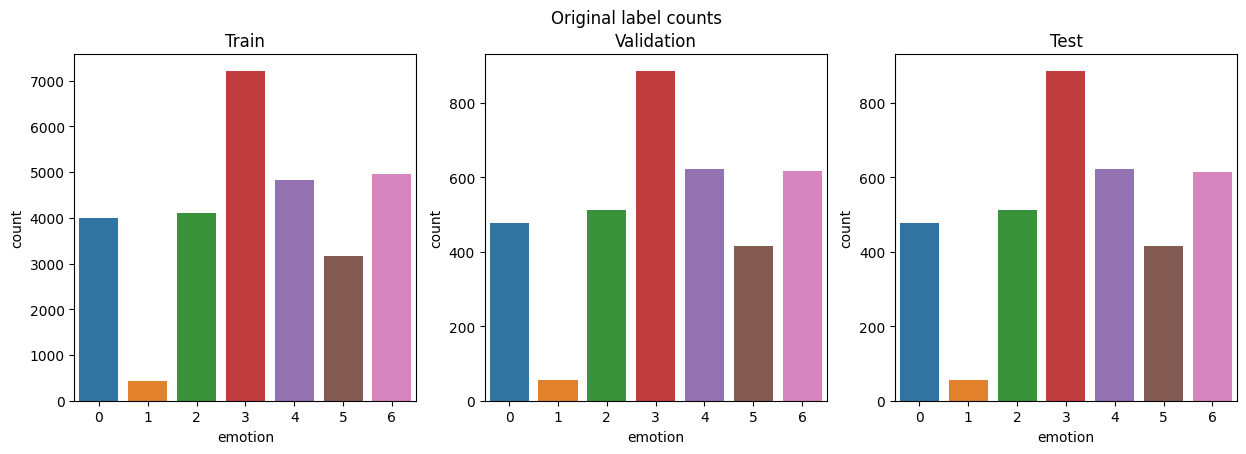

In [ ]:
plt.figure(figsize=(15, 4.5))
plt.subplot(1,3,1)
sns.countplot(data=train, x='emotion')
plt.title("Train")
plt.subplot(1,3,2)
sns.countplot(data=val, x='emotion')
plt.title("Validation")
plt.subplot(1,3,3)
sns.countplot(data=test, x='emotion')
plt.title("Test")
plt.suptitle("Original label counts")
plt.show()

In [ ]:
# function to generate augmented images from existing images

def image_augment(myimgs, n):
    datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.25, 1.5],
        fill_mode="nearest"
    )

    augmented_images = []
    for image_array in myimgs:
        image_array = np.expand_dims(image_array, axis=0)*255       # Batch first required
        for _ in range(n):
            augmented_image_gen = datagen.flow(image_array, batch_size=1)

            augmented_image = augmented_image_gen.next()[0]
            augmented_images.append(augmented_image)

    return augmented_images

In [ ]:
sorted(Counter(train.emotion).items())

[(0, 3995), (1, 436), (2, 4097), (3, 7215), (4, 4830), (5, 3171), (6, 4965)]

In [ ]:
# define (randomly how many images to sample, how many augmented images created from each sample)
img_os = {0: (2000, 3), 1: (400, 10), 2: (2000, 3), 4: (2500, 2), 5: (1000, 3), 6: (2500, 1)}
random.seed(9)


for k, v in img_os.items():
    em = train[train.emotion==k].reset_index(drop=True)
    rids = random.sample(list(em.index), v[0])
    myimgs = np.stack([em.pixels.loc[x] for x in rids])

    aim = image_augment(myimgs, v[1])

    aug_df = pd.DataFrame(columns=['emotion', 'pixels'])
    aug_df.emotion = [k] * len(aim)
    aug_df.pixels = aim

    train = pd.concat([train, aug_df], ignore_index=True).reset_index(drop=True)


# reshape to channel first to match Conv2d input shape in pytorch
train.pixels = train.pixels.apply(lambda x: x.reshape(1, 48, 48))
val.pixels = val.pixels.apply(lambda x: x.reshape(1, 48, 48))
test.pixels = test.pixels.apply(lambda x: x.reshape(1, 48, 48))


In [ ]:
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

X_train, X_val, X_test = train.pixels, val.pixels, test.pixels
y_train, y_val, y_test = train.emotion, val.emotion, test.emotion

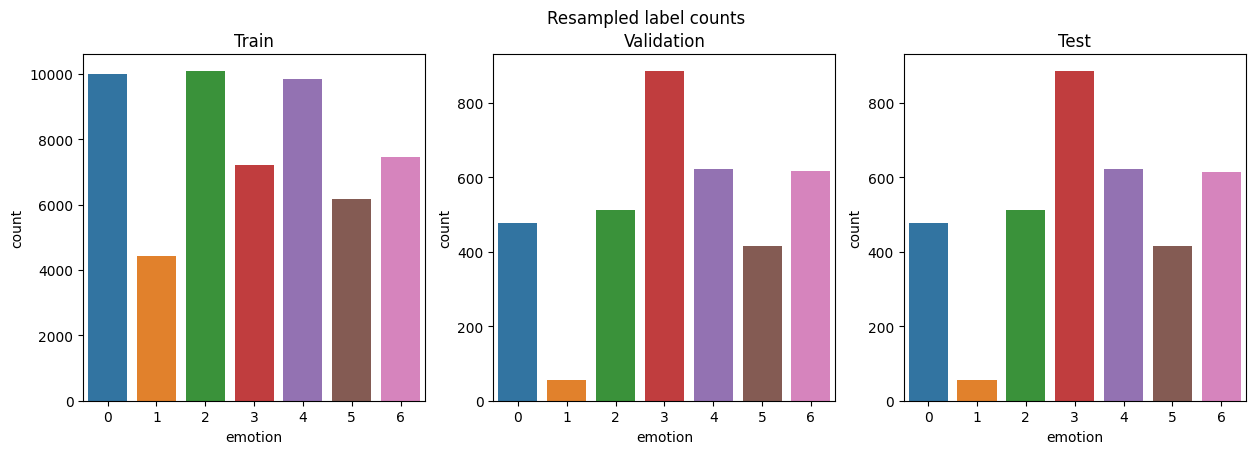

In [ ]:
plt.figure(figsize=(15, 4.5))
plt.subplot(1,3,1)
sns.countplot(data=pd.DataFrame(y_train, columns=['emotion']), x='emotion')
plt.title("Train")
plt.subplot(1,3,2)
sns.countplot(data=pd.DataFrame(y_val, columns=['emotion']), x='emotion')
plt.title("Validation")
plt.subplot(1,3,3)
sns.countplot(data=pd.DataFrame(y_test, columns=['emotion']), x='emotion')
plt.title("Test")
plt.suptitle("Resampled label counts")
plt.show()

In [ ]:
# obtain class weights to assist class imbalance mitigation

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                        classes=np.unique(y_train),
                                        y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

In [ ]:
X_train = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X_train])
X_val = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X_val])
X_test = torch.stack([torch.tensor(x, dtype=torch.float32) for x in X_test])

y_train = torch.tensor(y_train, dtype=torch.int64)
y_val = torch.tensor(y_val, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

# Residual Block

In [ ]:
class residual_block(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        # res layer 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # res layer 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # residual path
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )

        self.activation = nn.ReLU()


    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + self.shortcut(x)
        out = self.activation(out)

        return out

# Non-local block

In [ ]:
class non_local(nn.Module):

    def __init__(self, in_channels):
        super().__init__()

        self.theta = nn.Conv2d(in_channels, in_channels//2, kernel_size=1, stride=1, padding=0)
        self.phi = nn.Conv2d(in_channels, in_channels//2, kernel_size=1, stride=1, padding=0)
        self.g = nn.Conv2d(in_channels, in_channels//2, kernel_size=1, stride=1, padding=0)

        self.W = nn.Conv2d(in_channels//2, in_channels, kernel_size=1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(in_channels)
        self.dropout = nn.Dropout(dropout)


    def forward(self, x):

        # Following the gaussian embedding method
        theta = self.theta(x)
        phi = self.phi(x)
        g = self.g(x)

        shape = g.shape
        bat, ch, h, w = shape[0], shape[1], shape[2], shape[3]

        # reshaping N, C, H, W to N, C, H*W for matrix multiplication
        theta = theta.view(bat, ch, -1)
        phi = phi.view(bat, ch, -1)
        g = g.view(bat, ch, -1)

        g = torch.transpose(g, 1, 2)

        out = torch.transpose(theta, 1, 2) @ phi
        out = F.softmax(out, dim=-1)

        out = out @ g

        # reinstating N, C H, W shape
        out = torch.transpose(out, 1, 2).view(bat, ch, h, w)

        out = self.W(out)
        out = self.bn(out)

        out = out + x
        out = self.dropout(out)

        return out

# ResNet 18

In [ ]:
class resnet(nn.Module):

    def __init__(self):
        super().__init__()

        n = 64

        # Conv 1
        self.conv1 = nn.Conv2d(1, n, kernel_size=7, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(n)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)


        self.conv2 = nn.ModuleList()
        self.conv3 = nn.ModuleList()
        self.conv4 = nn.ModuleList()
        self.conv5 = nn.ModuleList()

        # conv 2 ~ residual block 1
        for ip in [n]*2:
            self.conv2.append(residual_block(ip, ip))

        self.nloc1 = non_local(n)

        # conv 3 ~ residual block 2
        for ip in [n, 2*n]:
            op = 2*n if ip==n else ip
            self.conv3.append(residual_block(ip, op))

        # conv 4 ~ residual block 3
        for ip in [2*n, 4*n]:
            op = 4*n if ip==2*n else ip
            self.conv4.append(residual_block(ip, op))

        # conv 4 ~ residual block 4
        for ip in [4*n, 8*n]:
            op = 8*n if ip==4*n else ip
            self.conv5.append(residual_block(ip, op))


        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # fully connected dense layer
        self.fc = nn.Linear(8*n, 7)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2[0](x)
        x = self.nloc1(x)
        x = self.conv2[1](x)
        x = self.dropout(x)

        for l in self.conv3:
            x = l(x)
        x = self.dropout(x)

        for l in self.conv4:
            x = l(x)
        x = self.dropout(x)

        for l in self.conv5:
            x = l(x)
        x = self.dropout(x)

        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc(x)


        return x

In [ ]:
# function to estimmate accuracy and loss over each batch and return average

def get_losses():
    with torch.no_grad():
        model.eval()

        tloss = torch.zeros(int(np.ceil(len(X_train)/batch_size)))
        tacc = torch.zeros(int(np.ceil(len(X_train)/batch_size)))
        for id, i in enumerate(list(range(0, len(X_train), batch_size))):
            Xi = X_train[i: i+batch_size]
            yi = y_train[i: i+batch_size]
            Xi, yi =  Xi.to(device), yi.to(device)
            train_logits = model(Xi)

            tacc[id] = accuracy_score(yi.cpu(), torch.argmax(F.softmax(train_logits), axis=1).cpu())
            tloss[id] = F.cross_entropy(train_logits, yi).cpu()



        vloss = torch.zeros(int(np.ceil(len(X_val)/batch_size)))
        vacc = torch.zeros(int(np.ceil(len(X_val)/batch_size)))
        for id, i in enumerate(list(range(0, len(X_val), batch_size))):
            Xi = X_val[i: i+batch_size]
            yi = y_val[i: i+batch_size]
            Xi, yi =  Xi.to(device), yi.to(device)
            val_logits = model(Xi)

            vacc[id] = accuracy_score(yi.cpu(), torch.argmax(F.softmax(val_logits), axis=1).cpu())
            vloss[id] = F.cross_entropy(val_logits, yi).cpu()



        model.train()

    return tacc.mean(), vacc.mean(), tloss.mean(), vloss.mean()

In [ ]:
# model hyperparameters

device = 'cuda'
batch_size = 128
dropout = 0.35
learning_rate = 6e-3
decay_factor = 0.5      # learning rate decay (lr * decay_factor^epoch)
class_weights = class_weights.to(device)

In [ ]:
torch.manual_seed(9)

model = resnet()

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

model = model.to(device)

# defining optimizer AdamW with weight_decay for L2 regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [ ]:
train_acc = []
val_acc = []
train_loss = []
val_loss = []

for e in range(60):
    learning_rate = learning_rate*(decay_factor**e)
    for b in range(0, len(X_train), batch_size):

        X_input = X_train[b: b+batch_size]
        y_target = y_train[b: b+batch_size]

        X_input, y_target =  X_input.to(device), y_target.to(device)

        logits = model(X_input)

        losses = F.cross_entropy(logits, y_target, weight=class_weights)


        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


    ta, va, tl, vl = get_losses()

    train_acc.append(ta)
    val_acc.append(va)
    train_loss.append(tl)
    val_loss.append(vl)

    print(f"Epoch: {e+1}; ", end=' ')
    print(f"Training accuracy: {ta}, Validation accuracy: {va}")


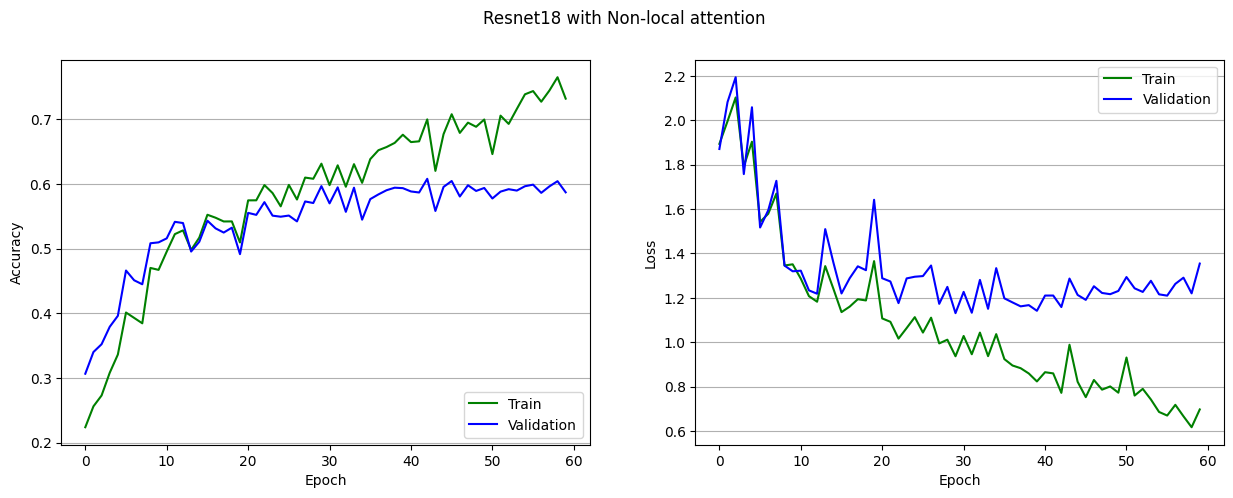

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, color='green', label="Train")
plt.plot(val_acc, color='blue', label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.grid(axis='y')

plt.subplot(1, 2, 2)
plt.plot(train_loss, color='green', label="Train")
plt.plot(val_loss, color='blue', label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(axis='y')

plt.suptitle("Resnet18 with Non-local attention")

plt.show()

In [ ]:
# calculate top 3 accuracy
accuracy3 = Accuracy(task="multiclass", num_classes=7, top_k=3).to(device)

with torch.no_grad():
    model.eval()

    tsloss = torch.zeros(int(np.ceil(len(X_test)/batch_size)))
    tsacc3 = torch.zeros(int(np.ceil(len(X_test)/batch_size)))

    for id, i in enumerate(list(range(0, len(X_test), batch_size))):
        Xi = X_test[i: i+batch_size]
        yi = y_test[i: i+batch_size]
        Xi, yi =  Xi.to(device), yi.to(device)
        test_logits = model(Xi)

        tsloss[id] = F.cross_entropy(test_logits, yi)
        tsacc3[id] = accuracy3(test_logits, yi)

        if id==0:
            preds = torch.argmax(F.softmax(test_logits), axis=1)
        else:
            preds = torch.cat((preds, torch.argmax(F.softmax(test_logits), axis=1)))

    model.train()


Test loss: 1.2910882234573364
Top 1 accuracy on test: 0.5979381443298969
Top 3 accuracy on test: 0.8760237097740173


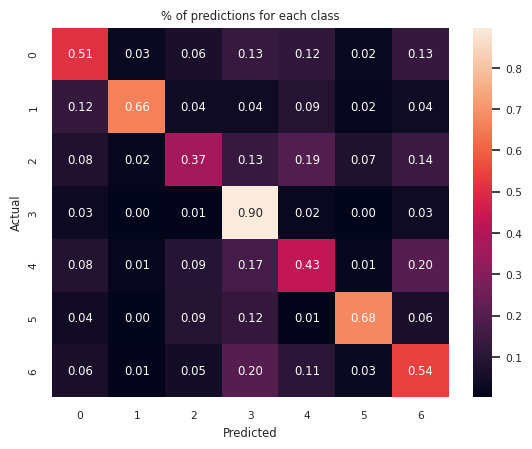

In [ ]:
preds = np.array(preds.cpu())

print(f"Test loss: {tsloss.mean()}")    # average loss over all batches
print(f"Top 1 accuracy on test: {accuracy_score(np.array(y_test.cpu()), preds)}")
print(f"Top 3 accuracy on test: {tsacc3.mean()}")   # average top3 accuracy over all batches

cmatrix = confusion_matrix(np.array(y_test.cpu()), preds)
cm_norm = cmatrix.astype('float') / cmatrix.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=0.7)
sns.heatmap(cm_norm, annot=True, fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f"% of predictions for each class")
plt.show()